# Ivy Individual Project

Dataset URL: http://www.kaggle.com/c/job-salary-prediction

## Libraries

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.model_selection import GridSearchCV

In [2]:
train_data = pd.read_csv("Train_rev1.csv")
selected_data = train_data.sample(n=2500, random_state=42) # randomly select 2500 data points

## Save to new data file to prevent using the big data every time
# selected_data.to_csv("selected_salary_data.csv"bb, index=False) 

In [7]:
data = pd.read_csv("selected_salary_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Id                  2500 non-null   int64 
 1   Title               2500 non-null   object
 2   FullDescription     2500 non-null   object
 3   LocationRaw         2500 non-null   object
 4   LocationNormalized  2500 non-null   object
 5   ContractType        685 non-null    object
 6   ContractTime        1859 non-null   object
 7   Company             2157 non-null   object
 8   Category            2500 non-null   object
 9   SalaryRaw           2500 non-null   object
 10  SalaryNormalized    2500 non-null   int64 
 11  SourceName          2500 non-null   object
dtypes: int64(2), object(10)
memory usage: 234.5+ KB


In [8]:
data.head(5)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,68062598,Business Account Manager,Business Account Manager Plumbing Heating Pro...,South West,South West London,NaN,permanent,BMS Sales Specialists,Sales Jobs,"22000 - 25000 per annum + Car,Mobile,Pension,L...",23500,totaljobs.com
1,69622111,Staff Nurse RGN/RMN Newtown Abbey Nights Ne...,Job Title; Staff Nurse RGN/RMN – NightsLocatio...,Newtownabbey,Newtownabbey,full_time,NaN,Regional Recruitment Services,Healthcare & Nursing Jobs,12.00/Hour,23040,staffnurse.com
2,66664026,Community Fundraising Manager,This dynamic international development charity...,London,London,full_time,permanent,TPP Not for Profit,Charity & Voluntary Jobs,33300 - 36400 per annum,34850,Third Sector Jobs
3,71015241,Conveyancing Executive,Large regional law firm require a residential ...,Hampshire,Hampshire,full_time,permanent,PTP Consulting,Legal Jobs,"From 18,000 to 27,000 per year",22500,TotallyLegal
4,71428553,Investment Compliance Analyst,This individual will work closely with the bus...,London South East,South East London,NaN,permanent,Michael Page Financial Services,Accounting & Finance Jobs,50000 to 60000 per annum,55000,totaljobs.com


In [9]:
data.describe()

,Id,SalaryNormalized
count,2.500000e+03,2500.000000
mean,6.973466e+07,33764.077200
std,2.976468e+06,16670.019292
min,2.957032e+07,5088.000000
25%,6.869990e+07,21500.000000
50%,6.993177e+07,30000.000000
75%,7.160582e+07,42500.000000
max,7.270293e+07,100000.000000


## EDA & Preprocess

### Categorical Variables

In [10]:
unique_location = data['LocationNormalized'].nunique()
unique_source = data['SourceName'].nunique()

location = data['LocationNormalized'].value_counts()
contract_type = data['ContractType'].value_counts()
contract_time = data['ContractTime'].value_counts()
source = data['SourceName'].value_counts()

print('Number of Unique Location:', unique_location, ', Location Category (Top 5):')
print(location.head(5))
print('-----------------------')
print('Contract Type Category:')
print(contract_type)
print('-----------------------')
print('Contract Time Category:')
print(contract_time)
print('-----------------------')
print('Number of Unique Source:', unique_source, ', Source Category (Top 5):')
print(source.head(5))

Number of Unique Location: 493 , Location Category (Top 5):
LocationNormalized
UK                   452
London               295
South East London    104
The City              67
Manchester            39
Name: count, dtype: int64
-----------------------
Contract Type Category:
ContractType
full_time    603
part_time     82
Name: count, dtype: int64
-----------------------
Contract Time Category:
ContractTime
permanent    1585
contract      274
Name: count, dtype: int64
-----------------------
Number of Unique Source: 125 , Source Category (Top 5):
SourceName
totaljobs.com       487
cv-library.co.uk    353
Jobcentre Plus      190
jobsite.co.uk       119
cwjobs.co.uk         72
Name: count, dtype: int64


### Missing Values

In [11]:
missing_value = data.isna().sum()
print('Missing values:')
print(missing_value)

Missing values:
Id                       0
Title                    0
FullDescription          0
LocationRaw              0
LocationNormalized       0
ContractType          1815
ContractTime           641
Company                343
Category                 0
SalaryRaw                0
SalaryNormalized         0
SourceName               0
dtype: int64


In [12]:
data.fillna('', inplace=True)
missing_value = data.isna().sum()
print('Missing values:')
print(missing_value)

Missing values:
Id                    0
Title                 0
FullDescription       0
LocationRaw           0
LocationNormalized    0
ContractType          0
ContractTime          0
Company               0
Category              0
SalaryRaw             0
SalaryNormalized      0
SourceName            0
dtype: int64


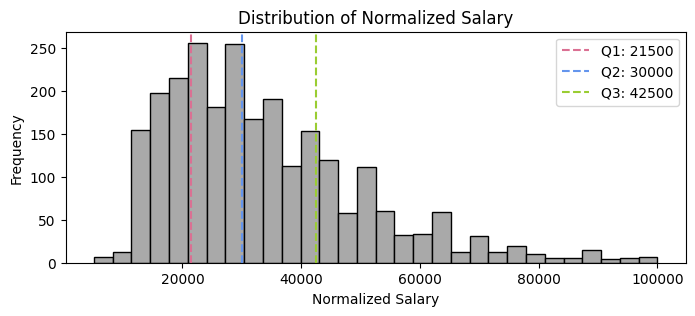

In [13]:
Q1 = data['SalaryNormalized'].quantile(0.25)
Q2 = data['SalaryNormalized'].quantile(0.5)
Q3 = data['SalaryNormalized'].quantile(0.75)

plt.figure(figsize=(8, 3))
plt.hist(data['SalaryNormalized'], bins=30, color='darkgrey', edgecolor='black')
plt.title('Distribution of Normalized Salary')
plt.xlabel('Normalized Salary')
plt.ylabel('Frequency')

plt.axvline(x=Q1, color='palevioletred', linestyle='--', label='Q1: {}'.format(int(Q1)))
plt.axvline(x=Q2, color='cornflowerblue', linestyle='--', label='Q2: {}'.format(int(Q2)))
plt.axvline(x=Q3, color='yellowgreen', linestyle='--', label='Q3: {}'.format(int(Q3)))

plt.legend()
plt.show()

### Identify high/low salary

In [14]:
process_data = data.copy()

process_data['HighSalary'] = (process_data['SalaryNormalized'] >= Q3).astype(int)

process_data.head(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,HighSalary
0,68062598,Business Account Manager,Business Account Manager Plumbing Heating Pro...,South West,South West London,,permanent,BMS Sales Specialists,Sales Jobs,"22000 - 25000 per annum + Car,Mobile,Pension,L...",23500,totaljobs.com,0
1,69622111,Staff Nurse RGN/RMN Newtown Abbey Nights Ne...,Job Title; Staff Nurse RGN/RMN – NightsLocatio...,Newtownabbey,Newtownabbey,full_time,,Regional Recruitment Services,Healthcare & Nursing Jobs,12.00/Hour,23040,staffnurse.com,0
2,66664026,Community Fundraising Manager,This dynamic international development charity...,London,London,full_time,permanent,TPP Not for Profit,Charity & Voluntary Jobs,33300 - 36400 per annum,34850,Third Sector Jobs,0


### Feature selection

In [15]:
process_data['Text'] = process_data['Title'] + ' ' + process_data['FullDescription'] + ' ' + \
    process_data['LocationNormalized'] + ' ' + process_data['ContractType'] + ' ' + \
    process_data['ContractTime'] + ' ' + process_data['Category'] + ' ' + process_data['SourceName'] 

### Preprocess and Lemmatization

In [28]:
clean_data = process_data.copy()

#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')

stop_words_set = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def pre_process(text, apply_lemmatization=False):
    
    # lowercase
    text=str(text).lower()

    # remove numbers followed by dot (like, "1.", "2.", etc)
    text=re.sub(r'[^\s]*[0-9]+[^\s]*', "", text)
    
    #remove tags
    text=re.sub(r"&lt;/?.*?&gt;"," &lt;&gt; ",text)

    #remove urls
    text=re.sub(r'[^\s]*(\.com|www\.|\.co\.uk)[^\s]*', "", text)

    #remove stars
    text=re.sub(r'[^\s]*[\*]+[^\s]*', "", text)
    
    # correct some misspellings and/or replace some text with others that might be easier to handle
    text=text.replace('do not', "don't")
    
    # remove special characters except spaces, apostrophes and dots
    text=re.sub(r"[^a-zA-Z0-9.']+", ' ', text)
    
    # lemmatization and remove stop words
    if apply_lemmatization:
        words = text.split()
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words_set]
        text = ' '.join(lemmatized_words)
    else:
        text = ' '.join([word for word in text.split() if word not in stop_words_set])
    
    return text

### Two version of clean data

In [29]:
clean_data['Text_process'] = clean_data['Text'].apply(pre_process)
clean_data['Text_process_Lem'] = clean_data['Text'].apply(lambda x: pre_process(x, apply_lemmatization=True))

In [34]:
X_no_lem = clean_data['Text_process']
X_lem = clean_data['Text_process_Lem']
y = clean_data['HighSalary']

### Train Test Split

In [35]:
X_no_lem_train, X_no_lem_test, y_train, y_test = train_test_split(X_no_lem, y, test_size=0.2, random_state=42)
X_lem_train, X_lem_test, y_train, y_test = train_test_split(X_lem, y, test_size=0.2, random_state=42)

## Model

### Count Vectorizer

In [45]:
count_vect = CountVectorizer(stop_words='english')

X_no_lem_train_count = count_vect.fit_transform(X_no_lem_train)
X_no_lem_test_count = count_vect.transform(X_no_lem_test)

X_lem_train_count = count_vect.fit_transform(X_lem_train)
X_lem_test_count = count_vect.transform(X_lem_test)

# Naive Bayes Model for No Lemmatization
nb_no_lem_count = MultinomialNB()
nb_no_lem_count.fit(X_no_lem_train_count, y_train)

# Naive Bayes Model for Lemmatization
nb_lem_count = MultinomialNB()
nb_lem_count.fit(X_lem_train_count, y_train)

# Prediction and Evaluation
y_pred_no_lem_count = nb_no_lem.predict(X_no_lem_test_count)
y_pred_lem_count = nb_lem.predict(X_lem_test_count)
print("Accuracy (No Lemmatization):", accuracy_score(y_test, y_pred_no_lem_count))
print("Classicication Report (No Lemmatization):")
print(classification_report(y_test, y_pred_no_lem_count))
print("Accuracy (Lemmatization):", accuracy_score(y_test, y_pred_lem_count))
print("Classicication Report (Lemmatization):")
print(classification_report(y_test, y_pred_lem_count))

Accuracy (No Lemmatization): 0.786
Classicication Report (No Lemmatization):
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       368
           1       0.58      0.68      0.63       132

    accuracy                           0.79       500
   macro avg       0.73      0.75      0.74       500
weighted avg       0.80      0.79      0.79       500

Accuracy (Lemmatization): 0.782
Classicication Report (Lemmatization):
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       368
           1       0.58      0.66      0.61       132

    accuracy                           0.78       500
   macro avg       0.72      0.74      0.73       500
weighted avg       0.79      0.78      0.79       500



### TFIDF Vectorizer

In [46]:
tfidf_vect = TfidfVectorizer(stop_words='english')

X_no_lem_train_tdidf = tfidf_vect.fit_transform(X_no_lem_train)
X_no_lem_test_tdidf = tfidf_vect.transform(X_no_lem_test)

X_lem_train_tdidf = tfidf_vect.fit_transform(X_lem_train)
X_lem_test_tdidf = tfidf_vect.transform(X_lem_test)

# Naive Bayes Model for No Lemmatization
nb_no_lem_tdidf = MultinomialNB()
nb_no_lem_tdidf.fit(X_no_lem_train_tdidf, y_train)

# Naive Bayes Model for Lemmatization
nb_lem_tdidf = MultinomialNB()
nb_lem_tdidf.fit(X_lem_train_tdidf, y_train)

# Prediction and Evaluation
y_pred_no_lem_tdidf = nb_no_lem.predict(X_no_lem_test_tdidf)
y_pred_lem_tdidf = nb_lem.predict(X_lem_test_tdidf)
print("Accuracy (No Lemmatization):", accuracy_score(y_test, y_pred_no_lem_tdidf))
print("Classicication Report (No Lemmatization):")
print(classification_report(y_test, y_pred_no_lem_tdidf))
print("Accuracy (Lemmatization):", accuracy_score(y_test, y_pred_lem_tdidf))
print("Classicication Report (Lemmatization):")
print(classification_report(y_test, y_pred_lem_tdidf))

Accuracy (No Lemmatization): 0.786
Classicication Report (No Lemmatization):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       368
           1       0.61      0.51      0.56       132

    accuracy                           0.79       500
   macro avg       0.72      0.70      0.71       500
weighted avg       0.78      0.79      0.78       500

Accuracy (Lemmatization): 0.786
Classicication Report (Lemmatization):
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       368
           1       0.62      0.50      0.55       132

    accuracy                           0.79       500
   macro avg       0.72      0.69      0.71       500
weighted avg       0.78      0.79      0.78       500



**By comparing the results, I decide to continue with the no lemmatization data.**

For each vectorizer, the no lemmatization version performs better by having higher recall and f1 score.

### Hyperparameter Tuning

In this step, I will find out the best n_gram and the best vectorizer for this dataset.

In [55]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('clf', MultinomialNB()),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2), (1, 3)],  # unigrams, bigrams, uni+bi, uni+bi+tri
    'vect': [CountVectorizer(stop_words='english'), TfidfVectorizer(stop_words='english')],  # Testing both vectorizers
}

grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=2)

# Assuming X_no_lem_train and y_train are your training data and labels
grid_search.fit(X_no_lem_train, y_train)

print("Best Score: %s" % grid_search.best_score_)
print("Best Parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 1); total time=   0.6s
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 1); total time=   0.6s
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 1); total time=   0.6s
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 1); total time=   0.7s
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 1); total time=   0.6s
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 2); total time=   1.9s
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 2); total time=   1.9s
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(2, 2); total time=   1.5s
[CV] END vect=CountVectorizer(stop_words='english'), vect__ngram_range=(1, 2); total time=   2.0s
[CV] END vect=CountVectorizer(stop_words='english'), vect_

In [57]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', ngram_range=(1, 1))),
    ('clf', MultinomialNB()),
])

pipeline.fit(X_no_lem_train, y_train)
y_pred = pipeline.predict(X_no_lem_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classicication Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.786
Classicication Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       368
           1       0.58      0.68      0.63       132

    accuracy                           0.79       500
   macro avg       0.73      0.75      0.74       500
weighted avg       0.80      0.79      0.79       500



# Final Model Accuracy: 0.786

# Final Model Confusion Matrix

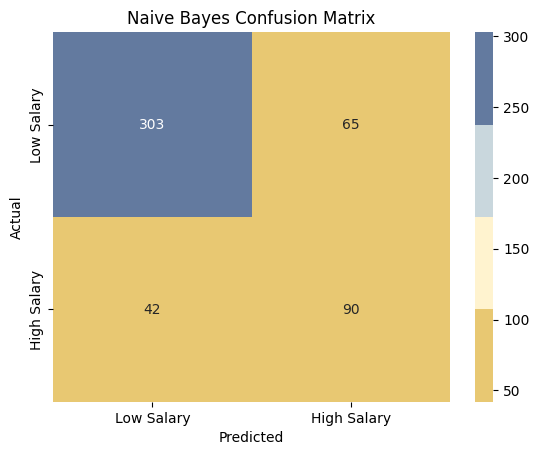

In [58]:
palette = ['#E8C872', '#FFF3CF', '#C9D7DD', '#637A9F']
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap=sns.color_palette(palette, as_cmap=True), 
            xticklabels=['Low Salary', 'High Salary'], yticklabels=['Low Salary', 'High Salary'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Naive Bayes Confusion Matrix')
plt.show()

In [59]:
# Access the vectorizer and classifier from the pipeline
vectorizer = pipeline.named_steps['vect']
classifier = pipeline.named_steps['clf']

# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get log probability of features given a class
low_salary_prob_sorted = classifier.feature_log_prob_[0, :].argsort()
high_salary_prob_sorted = classifier.feature_log_prob_[1, :].argsort()

# Top 10 words for each class
top10_low = [feature_names[i] for i in low_salary_prob_sorted[-10:]]
top10_high = [feature_names[i] for i in high_salary_prob_sorted[-10:]]

print("Top 10 words for class 0 (low salary):", top10_low)
print("Top 10 words for class 1 (high salary):", top10_high)

Top 10 words for class 0 (low salary): ['business', 'working', 'skills', 'manager', 'sales', 'team', 'role', 'jobs', 'work', 'experience']
Top 10 words for class 1 (high salary): ['skills', 'work', 'development', 'management', 'manager', 'jobs', 'role', 'team', 'business', 'experience']
